In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ex3data1.mat
/kaggle/input/ex3weights.mat


# Programming Exercise 3: Multi-class Classification and Neural Networks

# 1 Multi-class classification

In [2]:
from scipy.io import loadmat
data = loadmat('../input/ex3data1.mat')
X = data['X']
y = data['y']
print(X.shape) # (5000, 400 (20 x 20))
print(y.shape) # (5000, 1) 1-9, 10 as 0

m, n = X.shape
num_labels = 10

(5000, 400)
(5000, 1)


## 1.2 Visualizing the data

In [3]:
'''
source 
https://github.com/nex3z/machine-learning-exercise/blob/master/coursera-machine-learning-python/ex3/display_data.py
'''
import matplotlib.pyplot as plt

def display_data(X, tile_width=-1, padding=0):
    """
    Display data in a nice grid

    Parameters
    ----------
    X : ndarray, shape (n_samples, sample_size)
        A collection of sample data to be displayed, where n_samples is the number of samples and sample_size is the
        size of each sample.
    tile_width : int
        Width of each image.
    padding : int
        Padding around the image.
    """
    m, n = X.shape
    padding = int(padding)
    tile_width = int(tile_width)
    
    if tile_width < 0:
        tile_width = int(np.round(np.sqrt(n)))
    tile_height = int(n / tile_width)

    display_rows = int(np.floor(np.sqrt(m)))
    display_columns = int(np.ceil(m / display_rows))

    tile_height_padded = tile_height + padding * 2
    tile_width_padded = tile_width + padding * 2
    
    data = np.zeros((int(display_rows * tile_height_padded), int(display_columns * tile_width_padded)))

    for i in range(display_rows):
        for j in range(display_columns):
            tile = format_tile(X[i * display_rows + j,], tile_width, padding)
            tile = tile.T
            data[i * tile_height_padded:(i + 1) * tile_height_padded,
                 j * tile_width_padded:(j + 1) * tile_width_padded] = tile

    plt.imshow(data, cmap='gray', extent=[0, 1, 0, 1])


def format_tile(x, width=-1, padding=0):
    """
    Format raw data to a 2-d array for plot.

    Parameters
    ----------
    x : ndarray, shape (sample_size, )
        Sample data, 1-d array, where sample_size is the size of each sample.
    width : int
        Width of the image.
    padding : int
        Padding around the image.

    Returns
    -------
    ndarray
        The formatted 2-d array data for plot.
    """
    padding = int(padding)
    width = int(width)
    
    if width < 0:
        width = int(np.round(np.sqrt(len(x))))
    height = len(x) / width

    tile = np.ones((int(height + padding * 2), int(width + padding * 2)))

    for i in range(int(padding), int(height + padding)):
        tile[i, padding:(padding + width)] = x[((i - padding) * width):((i - padding) * width + width)]

    return tile

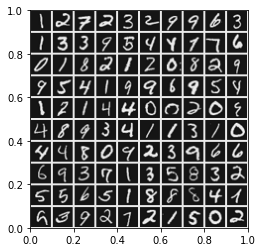

In [4]:
rand_indices = np.random.permutation(m)
sel = X[rand_indices[0:100], :]
plt.figure()
display_data(sel, padding=1)
plt.show()

## 1.3 Vectorizing logistic regression

In [5]:
def sigmoid(z):
    '''
    SIGMOID Compute sigmoid functoon
    '''
    return 1/(1+np.exp(-z))

In [6]:
def lrCostFunction(theta, X, y, param_lambda, reg = False):
    '''
    LRCOSTFUNCTION Compute cost and gradient for logistic regression with regularization
    
    J = LRCOSTFUNCTION(theta, X, y, lambda) computes the cost of using theta as the parameter 
        for regularized logistic regression and the gradient of the cost w.r.t. to the parameters. 
    
    X - shape (m, n)
    theta - nparray shape (n+1,)
    '''
    # Initialize some useful values
    m, n = X.shape # number of training examples
    
    # add intercept term to X
    X = np.hstack([np.ones((m, 1)), X]) # (m,n+1)
    y = y.reshape(m,1)
    theta = theta.reshape(n+1,1)
    
    # h(x)
    y_prob = sigmoid(X @ theta) # (m,1)
      
    # sum(-log(h(x))) for y = 1
    y_1_useful = y_prob * y 
    J_y_1_sum = -sum(np.log(y_1_useful[y_1_useful!=0]))
    
    # sum(-log(h(x))) for y = 0
    y_0_useful = (1 - y_prob) * (1-y)
    J_y_0_sum = -sum(np.log(y_0_useful[y_0_useful!=0]))
    
    # regularization term
    loss_reg = sum(theta[1:]**2)*param_lambda/(2*m)
    if reg:
        J = (J_y_1_sum + J_y_0_sum)/m + loss_reg
    else:
        J = (J_y_1_sum + J_y_0_sum)/m
    
    return J

def lrGradientFunction(theta, X, y, param_lambda, reg = False):
    '''
    computes the gradient of the cost w.r.t. to the parameters.
    X - shape (m, n)
    theta - nparray shape (n+1,)
    '''
    # Initialize some useful values
    m, n = X.shape # number of training examples
    
    # add intercept term to X
    X = np.hstack([np.ones((m, 1)), X]) # (m,n+1)
    y = y.reshape(m,1)
    theta = theta.reshape(n+1,1)
    
    # h(x)
    y_prob = sigmoid(X @ theta) # (m,1)
    
    if reg:
        grad = (X.T @ (y_prob - y))/m + np.vstack([0, param_lambda*theta[1:]/m]) # (n+1,1)
    else:
        grad = (X.T @ (y_prob - y))/m

    return grad.reshape(n+1,)

In [7]:
# Test case for lrCostFunction
print('\nTesting lrCostFunction() with regularization');

theta_t = np.array([-2, -1, 1, 2])
X_t = ((np.arange(1, 16)).reshape(5,3, order = 'F'))/10 # order = F - order along column (instead of row)
print(X_t)
y_t = np.array([1,0,1,0,1]) >= 0.5
lambda_t = 3

J = lrCostFunction(theta_t, X_t, y_t, lambda_t, reg = True)
grad = lrGradientFunction(theta_t, X_t, y_t, lambda_t, reg = True)
print(grad.shape)

print('\nCost: {:.6f}\n'.format(J[0]))
print('Expected cost: 2.534819\n')
print('Gradients:\n{0[0]:.6f}\n{0[1]:.6f}\n{0[2]:.6f}\n{0[3]:.6f}\n'.format(grad.flatten().tolist()))
print('Expected gradients:\n 0.146561\n -0.548558\n 0.724722\n 1.398003\n')



Testing lrCostFunction() with regularization
[[0.1 0.6 1.1]
 [0.2 0.7 1.2]
 [0.3 0.8 1.3]
 [0.4 0.9 1.4]
 [0.5 1.  1.5]]
(4,)

Cost: 2.534819

Expected cost: 2.534819

Gradients:
0.146561
-0.548558
0.724722
1.398003

Expected gradients:
 0.146561
 -0.548558
 0.724722
 1.398003



In [8]:
# Test case for lrCostFunction
print('\nTesting lrCostFunction() without regularization');

theta_t = np.array([-2, -1, 1, 2])
X_t = ((np.arange(1, 16)).reshape(5,3, order = 'F'))/10 # order = F - order along column (instead of row)
print(X_t)
y_t = np.array([1,0,1,0,1]) >= 0.5
lambda_t = 3

J = lrCostFunction(theta_t, X_t, y_t, lambda_t)
grad = lrGradientFunction(theta_t, X_t, y_t, lambda_t)
print(grad.shape)

print('\nCost: {:.6f}\n'.format(J))
print('Gradients:\n{0[0]:.6f}\n{0[1]:.6f}\n{0[2]:.6f}\n{0[3]:.6f}\n'.format(grad.flatten().tolist()))


Testing lrCostFunction() without regularization
[[0.1 0.6 1.1]
 [0.2 0.7 1.2]
 [0.3 0.8 1.3]
 [0.4 0.9 1.4]
 [0.5 1.  1.5]]
(4,)

Cost: 0.734819

Gradients:
0.146561
0.051442
0.124722
0.198003



supplementary: using two optimization algorithms

In [9]:
from scipy.optimize import fmin_cg, fmin_tnc, minimize, fmin_bfgs

temp0 = fmin_tnc(func = lrCostFunction, x0 = theta_t, fprime = lrGradientFunction, 
                args = (X_t, y_t, lambda_t, True))
theta_tnc = temp0[0]
print('Cost at theta found by fmin_tnc with regularization: {}\n'.format(lrCostFunction(theta_tnc, X_t, y_t, lambda_t, True)))
temp1 = fmin_tnc(func = lrCostFunction, x0 = theta_t, fprime = lrGradientFunction, 
                args = (X_t, y_t, lambda_t, False))
theta_tnc = temp1[0]
print('Cost at theta found by fmin_tnc without regularization: {}\n'.format(lrCostFunction(theta_tnc, X_t, y_t, lambda_t, False)))

m, n = X_t.shape
# nonlinear conjugate gradient algorithm - dealing with a large number of parameters
temp2 = fmin_cg(lrCostFunction, x0 = theta_t, fprime = lrGradientFunction, args = (X_t, y_t.reshape(m,1), lambda_t, True))
# gradient function need to return 1d array for fmin_cg or minimize(method = 'CG') to work
theta_cg = temp2 #(n+1, )
print('Cost at theta found by fmin_cg with regularization: {}\n'.format(lrCostFunction(theta_tnc, X_t, y_t, lambda_t, True)))

temp3 = fmin_cg(lrCostFunction, x0 = theta_t, fprime = lrGradientFunction, args = (X_t, y_t.reshape(m,1), lambda_t, False))
# gradient function need to return 1d array for fmin_cg or minimize(method = 'CG') to work
theta_cg = temp3 #(n+1, )
print('Cost at theta found by fmin_cg without regularization: {}\n'.format(lrCostFunction(theta_tnc, X_t, y_t, lambda_t, False)))

Cost at theta found by fmin_tnc with regularization: [0.67301167]

Cost at theta found by fmin_tnc without regularization: 0.6730116670092566

Optimization terminated successfully.
         Current function value: 0.673012
         Iterations: 14
         Function evaluations: 22
         Gradient evaluations: 22
Cost at theta found by fmin_cg with regularization: [2.1249041]

Optimization terminated successfully.
         Current function value: 0.673012
         Iterations: 12
         Function evaluations: 25
         Gradient evaluations: 25
Cost at theta found by fmin_cg without regularization: 0.6730116670092566



## 1.4 One-vs-all classification

In [10]:
def oneVsAll(X, y, num_labels, lambda_param, reg = False):
    '''
    ONEVSALL trains multiple logistic regression classifiers and returns all
    the classifiers in a matrix all_theta, where the i-th row of all_theta 
    corresponds to the classifier for label i
    
    [all_theta] = ONEVSALL(X, y, num_labels, lambda) trains num_labels
    logistic regression classifiers and returns each of these classifiers
    in a matrix all_theta, where the i-th row of all_theta corresponds 
    to the classifier for label i (k, n+1)
    '''
    m, n = X.shape
    y = y.reshape(m,1)
    theta_initial = np.zeros((n+1, 1))
    
    y_categories = np.unique(y)
    all_theta = np.empty((num_labels, n+1))
    
    # train parameters for each category
    for i, j in enumerate(y_categories):
        y_j = (y == j)*1 # turn into binary classification, convert boolean to int
        if reg:
            temp = fmin_cg(lrCostFunction, x0 = theta_initial, fprime = lrGradientFunction, 
                       args = (X, y_j, lambda_param, True))
        else:
            temp = fmin_cg(lrCostFunction, x0 = theta_initial, fprime = lrGradientFunction, 
                       args = (X, y_j, lambda_param, False))
        all_theta[i,:] = temp
    
    return y_categories, all_theta

In [11]:
print('\nTraining One-vs-All Logistic Regression...\n')

lambda_param = 0.1
y_categories, all_theta_reg = oneVsAll(X, y, num_labels, lambda_param, True)
y_categories, all_theta = oneVsAll(X, y, num_labels, lambda_param, False)


Training One-vs-All Logistic Regression...

Optimization terminated successfully.
         Current function value: 0.013116
         Iterations: 117
         Function evaluations: 456
         Gradient evaluations: 456
Optimization terminated successfully.
         Current function value: 0.050808
         Iterations: 246
         Function evaluations: 758
         Gradient evaluations: 758
Optimization terminated successfully.
         Current function value: 0.057615
         Iterations: 209
         Function evaluations: 626
         Gradient evaluations: 626
Optimization terminated successfully.
         Current function value: 0.033078
         Iterations: 201
         Function evaluations: 665
         Gradient evaluations: 665
Optimization terminated successfully.
         Current function value: 0.054464
         Iterations: 284
         Function evaluations: 862
         Gradient evaluations: 862
Optimization terminated successfully.
         Current function value: 0.018259


Evaluate the accuracy of the trained model

In [12]:
def predictOneVsAll(all_theta, X):
    '''
    PREDICT Predict the label for a trained one-vs-all classifier. The labels 
    are in the range 1..K, where K - num_class 
    
    p = PREDICTONEVSALL(all_theta, X) will return a vector of predictions
    for each example in the matrix X. Note that X contains the examples in
    rows. all_theta is a matrix where the i-th row is a trained logistic
    regression theta vector for the i-th class. You should set p to a vector
    of values from 1..K (e.g., p = [1; 3; 1; 2] predicts classes 1, 3, 1, 2
    for 4 examples) 
    '''
    m, n = X.shape
    num_labels = all_theta.shape[0]
    X_add0 = np.hstack([np.ones((m,1)), X])
    
    z = X_add0 @ all_theta.T
    y_pred = y_categories[np.argmax(sigmoid(z), axis = 1)]
    
    return y_pred.reshape(m,1)

In [13]:
pred_reg = predictOneVsAll(all_theta_reg, X)
pred = predictOneVsAll(all_theta, X)

print('\nTraining Set Accuracy with regularization: {:.4f}\n'.format(np.mean(pred_reg == y) * 100))
print('\nTraining Set Accuracy without regularization: {:.4f}\n'.format(np.mean(pred == y) * 100))



Training Set Accuracy with regularization: 96.4600


Training Set Accuracy without regularization: 98.2000



# Supplementary


## A. multinomial logistic regression with softmax and cross entropy

## stochastic gradient descent

In [14]:
class LogisticRegression(object):
    """ Multinomial Linear Regression

    @attrs:
        weights: a parameter of the model
        alpha: the step size in gradient descent
        n_features: the number of features
        n_classes: the number of classes
    """
    def __init__(self, n_features, n_classes, reg):
        """ Initializes a LogisticRegression classifer. """
        self.alpha = 0.05  # tune this parameter
        self.n_features = n_features
        self.n_classes = n_classes
        self.weights = np.zeros((n_features, n_classes)) #(n,k)
        self.reg = reg
        self.lambda_param = 0.1
        
    def train(self, X, y):
        """ 
        
        @params:
            X - (m,n)
            y - (m,1)
        @return:
            None
        """
        #TODO
       
        w_new = self.weights.copy() #(n,k)
        alpha = self.alpha
        
        '''
        m, n = X.shape
        y = y.reshape(m,)
        
        #print(X.shape)
        #print(y.shape)
        #temp = fmin_cg(self.costFunction, x0 = w_new, fprime = self.gradientFunction, 
        #               args = (X, y))
        temp = fmin_tnc(func = self.costFunction, x0 = w_new, fprime = self.gradientFunction, 
                        args = (X, y))
        #temp = fmin_bfgs(self.costFunction, x0 = w_new, fprime = self.gradientFunction, args = (X, y))
        
        '''
        #Trains the model, using stochastic gradient descent
        
        train_data = np.hstack([X, y])
        m,n = X.shape
        
        step_count = 0
        loss_new = 1
        loss_old = 2
        loss = []
        while abs((loss_new - loss_old)/loss_old) >= 0.005:
            #print('loss_old',loss_old)

            #condition for convergence (w的norm或Loss)
            np.random.shuffle(train_data)

            for example in train_data:
                w_old = w_new.copy()
                l = example[:-1] @ w_old # (1,n) @ (n,k) - (1,k)
                p = self._softmax(l) # h(x)
                grad_l = p.copy()
                #print(grad_l.shape)
                grad_l[int(example[-1])] -= 1 #d L/d l_i #1*10
                grad = example[:-1].reshape(self.n_features,-1)@grad_l.reshape(-1,self.n_classes) # (n,1) @ (1,k)
                if self.reg:
                    w_new = w_old * (1-alpha*self.lambda_param/m) - alpha*grad
                else:
                    w_new = w_old - alpha*grad

            #print('step',step_count)

            #loss function for the new w
            if step_count % 5 == 0:
                loss_old = loss_new
                loss_new = 0
                for example in train_data:
                    l = example[:-1] @ w_new
                    p = self._softmax(l)
                    loss_new -= np.log(p[int(example[-1])])
                if self.reg:
                    loss_new -= np.sum(w_new**2)*self.lambda_param/(2*m)
                
                #print('loss_new',loss_new)
            #print('diff',abs((loss_new - loss_old)/loss_old))

            loss.append(loss_new)
            step_count += 1

        #print('final loss',loss)
        #print('final step#',step_count)
        self.weights = w_new.copy()
        self.loss = loss
        self.steps = step_count
        '''
        loss = self.costFunction(temp, X, y)
            
        self.weights = temp.copy()
        self.loss = loss
        '''
        
    def costFunction(self, theta, X, y):
        # theta - (n,k)
        # Initialize some useful values
        m, n = X.shape # number of training examples
        y = y.reshape(m,1)
        y_categories = np.unique(y) # 0 to k-1
        
        #print(len(theta))
        theta = theta.reshape(self.n_features, self.n_classes)
        
        z = X @ theta #(m,k)
        
        # h(x)
        y_prob = np.apply_along_axis(self._softmax, 1, X @ theta) # (m,1)
        
        J = -np.sum(np.log(np.take_along_axis(y_prob, y, 1)))
        
        # regularization term
        loss_reg = np.sum(theta**2)*self.lambda_param/(2*m)
            
        if self.reg == 1:
            J_final = J + loss_reg
        else:
            J_final = J
        
        return J_final
    
    def gradientFunction(self, theta, X, y):
        # theta - (n,k)
        # Initialize some useful values
        m, n = X.shape # number of training examples
        y = y.reshape(m,1)
        #y_categories = np.unique(y) # 0 to k-1
        theta = theta.reshape(self.n_features, self.n_classes)
        
        # h(x)
        #print(X.shape)
        #print(theta.shape)
        y_prob = np.apply_along_axis(self._softmax, 1, X @ theta) # (m,1)
        
        
        if self.reg == 1:
            grad = (X.T @ (y_prob - y))/m + self.lambda_param*theta/m
        else:
            grad = (X.T @ (y_prob - y))/m
        #print(grad.shape)
        
        return grad.reshape(self.n_features * self.n_classes,)
        

    def predict(self, X):
        """ Compute predictions based on the learned parameters

        @params:
            data: the training data as a namedtuple with two fields: inputs and labels
        @return:
            a numpy array of predictions
        """
        #TODO
        predict_labels = []
    
        all_theta = self.weights.copy()
        predict_labels = all_theta.shape[0]
        
        #print(X.shape)
        #print(all_theta.shape)
        
        z = X @ all_theta
        y_pred = np.argmax(sigmoid(z), axis = 1)
    
        return y_pred.reshape(m,1)

    def accuracy(self, X, y):
        """ Outputs the accuracy of the trained model on a given dataset (data).

        @params:
            X - (m,n)
            y - (m,1)
        @return:
            a float number indicating accuracy (between 0 and 1)
        """
        #TODO
        predicted_labels = self.predict(X)
        actual_labels = y
        accuracy_prob = sum(predicted_labels == actual_labels)/len(actual_labels)

        return accuracy_prob

    def _softmax(self, x):
        """ 
        @params:
            x: the original array
        @return:
            an array with softmax applied elementwise.
        """
        e = np.exp(x - np.max(x)) # avoid underflow
        return e / np.sum(e)

In [15]:
data = loadmat('../input/ex3data1.mat')
X = data['X']
y = data['y']
print(X.shape) # (5000, 400 (20 x 20))
print(y.shape) # (5000, 1) 1-9, 10 as 0

m, n = X.shape
num_labels = 10
y[y==10] = 0

model = LogisticRegression(n, num_labels, True)
model.train(X,y)
print('\nTraining Set Accuracy with regularization: {:.4f}%\n'.format(model.accuracy(X, y)[0] * 100))

model = LogisticRegression(n, num_labels, False)
model.train(X,y)
print('\nTraining Set Accuracy without regularization: {:.4f}%\n'.format(model.accuracy(X, y)[0] * 100))


(5000, 400)
(5000, 1)

Training Set Accuracy with regularization: 97.6200%


Training Set Accuracy without regularization: 98.3600%



## B. sklearn

In [16]:
from sklearn.linear_model import LogisticRegression

regression_model_reg = LogisticRegression(penalty='l2', solver='lbfgs', multi_class='multinomial', max_iter = 400)
regression_model_reg.fit(X, y.reshape(m,))
# solver - newton-cg/lbfgs

regression_model = LogisticRegression(penalty='none', solver='lbfgs', multi_class='multinomial', max_iter = 400)
regression_model.fit(X, y.reshape(m,))

LogisticRegression(max_iter=400, multi_class='multinomial', penalty='none')

In [17]:
#regression_model.predict(X)

print('Train Accuracy with regularization: {:.4f}%\n'.format(regression_model_reg.score(X,y)*100))
print('Train Accuracy without regularization: {:.4f}%\n'.format(regression_model.score(X,y)*100))


Train Accuracy with regularization: 96.2400%

Train Accuracy without regularization: 100.0000%

